<a href="https://colab.research.google.com/github/james-lucius/qureca_ADEQUATE/blob/main/M9_2222_QNNs_2_2_1_Training_a_QNN_Exercises_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://gitlab.com/qworld/qeducation/educational-materials/adequate-qbook1/raw/main/qworld/images/adq_1.png" align="left" width=450>

_prepared by Claudia Zendejas-Morales_

### 2.2.1 Training a QNN Exercises Solutions

##### <font color="#08b806">Please run the following (hidden) cell; it is required to set up the environment for Google Colab

In [1]:
import IPython

def in_colab():
    try:
        import google.colab
        return True
    except:
        return False

if in_colab():
    !pip install qiskit[visualization]==1.4.2 &> /dev/null # use "&> /dev/null" so that the standard output of the installation is not displayed
    !pip install qiskit-machine-learning==0.8.2 &> /dev/nul

import warnings
warnings.filterwarnings("ignore")

<a name="task1"></a>
## Task 1

At the end of section "2.2 Training a QNN," we reviewed a very simple example that started in state |0> and aimed to end in state |1> with a single rotation around the y-axis. To achieve this, a single parameter was optimized.

Create a cost function to find the parameter needed to move from state $|0\rangle$ to state $|-i\rangle$ (along the negative _y-axis_).

To test your cost function, copy the code from section "2.2 Training a QNN," but now pass your new function as a parameter to `minimize`, and use `initial_guess = 0`.

You can use the same code from the def `average_cost(angle, fn_costo, shots=2000)` function, just copy it.

Corroborate the result with the help of a Bloch sphere, similar to the example shown in section 2.2.

### Solution

In [2]:
def cost_state_minus_i(prob_meas_state_minus_i):
   return (prob_meas_state_minus_i - 0.5)**2      # we are interested in a positive value so that the cost reaches 0

You can use the same code from the def `average_cost(angle, fn_costo, shots=2000)` function, just copy it.

In [3]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi
from math import radians, degrees

def average_cost(angle, fn_costo, shots=2000):

    qc = QuantumCircuit(1)                      # we only need one qubit
                                                # already start in state |0> (no need for encoding)

    qc.ry(radians(angle[0]), 0)                 # rotation aroud Y by an amount of 'angle' degrees (variational form)
                                                # 'ry' must receive the parameter in radians

    sv = qi.Statevector(qc)                     # we do a simple simulation
    counts = sv.sample_counts(shots=shots)      # we get the counts

    average_state_1 = (counts['1'] if '1' in counts else 0)/shots    # we calculate the average of the state obtained

    average_cost = fn_costo(average_state_1)    # we evaluate the cost function

    print('Try: angle =', angle, 'produces an average cost =', average_cost)    # show the cost for this step

    return average_cost

In [4]:
from scipy.optimize import minimize


initial_guess = 0

result = minimize(average_cost,                   # we use the same function that contains the quantum circuit
                  initial_guess,                  # we use the indicated initial value
                  args=(cost_state_minus_i,),     # we use the new cost function
                  method='Powell')                # we use the same optimization method

# The value searched must be very close to 90, it is possible that some execution does not find it, so run the cell again if this is the case

Try: angle = [0.] produces an average cost = 0.25
Try: angle = [0.] produces an average cost = 0.25
Try: angle = [1.] produces an average cost = 0.25
Try: angle = [2.618034] produces an average cost = 0.24950025
Try: angle = [5.23606803] produces an average cost = 0.24750625
Try: angle = [9.47213609] produces an average cost = 0.24453025
Try: angle = [48.09108968] produces an average cost = 0.11256025000000001
Try: angle = [110.57786964] produces an average cost = 0.033306249999999996
Try: angle = [109.17196968] produces an average cost = 0.026406249999999992
Try: angle = [85.84115027] produces an average cost = 0.0012959999999999983
Try: angle = [71.42191063] produces an average cost = 0.02559999999999999
Try: angle = [90.15097532] produces an average cost = 0.0002250000000000004
Try: angle = [89.24946557] produces an average cost = 6.2499999999997335e-06
Try: angle = [88.35697091] produces an average cost = 2.5000000000000045e-05
Try: angle = [178.49893113] produces an average cost =

Corroborate the result with the help of a Bloch sphere, similar to the example shown in section 2.2.

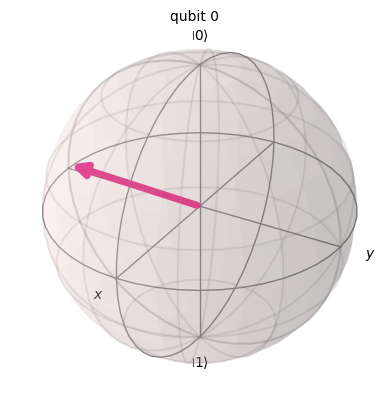

In [5]:
from qiskit.visualization import plot_bloch_multivector


qc = QuantumCircuit(1)
qc.rx(radians(result.x[0]), 0)      # The rotation must be around the x axis, in order to reach the state |-i>

sv = qi.Statevector(qc)
plot_bloch_multivector(sv)

## Task 2: Regression


We'll be using [Qiskit Machine Learning](https://qiskit-community.github.io/qiskit-machine-learning/) for the following tasks. The initial cell has already taken care of installing this library, so we only need to import what's necessary.

**Qiskit Machine Learning** introduces fundamental computational building blocks, such as quantum kernels and quantum neural networks, which are used in various applications, including classification and regression.

This library provides several classes to help us solve problems with classification and regression models, such as [NeuralNetworkClassifier](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkClassifier.html) and [NeuralNetworkRegressor](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkRegressor.html). Both classes take a [NeuralNetwork](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.neural_networks.NeuralNetwork.html) object as input and use it depending on the specific context.

We will work with a regression exercise: we will use our dataset, generating random numbers around a sine function (samples) so that our regression results behave exactly like a sine.

The code that does this is as follows:

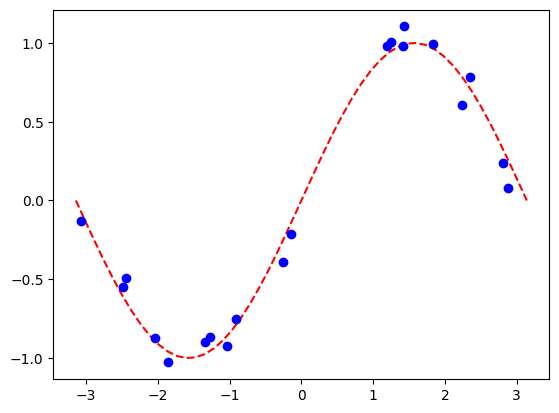

In [6]:
import matplotlib.pyplot as plt
import numpy as np

num_samples = 20                                           # number of samples to train the QNN

eps = 0.2                                                  # tolerance value (epsilon)

lb, ub = -np.pi, np.pi                                     # lower and upper limits for x

X_ = np.linspace(lb, ub, num=50).reshape(50, 1)            # generate 50 numbers in the range (lb, ub) to plot f

f = lambda x: np.sin(x)                                    # lambda function that calculates the sine

X = (ub - lb)*np.random.rand(num_samples, 1) + lb          # generate 20 samples randomly (num_samples)
                                                           # but in the interval (lb, ub)

y = f(X[:,0]) + eps*(2*np.random.rand(num_samples)-1)      # generate the results (vector 'y') randomly
                                                           # but following a sine function, and with tolerance of 'eps'
                                                           # that is, ± 0.2 above or below the sine function

plt.plot(X_, f(X_), 'r--')                                 # plot the function f (sine), using the 50 points in X_
plt.plot(X, y, 'bo')                                       # plot the samples
plt.show()

Now we are going to build our QNN.

<a name="task21"></a>
### Task 2.1: Feature Map

Create a feature map that is a quantum circuit with a single gate $R_y$ on a single qubit, since we only have one feature for each sample (the value $x$).

We need to make $R_y$'s angle argument to be a parameter, by using Qiskit's [Parameter](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Parameter) class. Name it `"x"`. Visit the link to see how.

### Solution

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# create a Parameter named 'x'
param_x = Parameter("x")

# create a circuit for the feature map
feature_map = QuantumCircuit(1, name="fm")

# add the parameterized ry gate
feature_map.ry(param_x, 0)

<a name="task22"></a>
### Task 2.2: Variational Form

Create a variational form (or ansatz) that is a quantum circuit with a single gate $R_y$ on a single qubit, since we only have one parameter $\theta$ to optimize for each sample.

We need to make $R_y$'s angle argument to be a parameter, by using Qiskit's [Parameter](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Parameter) class. Name it `"theta"`. Visit the link to see how.

### Solution

In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# create a Parameter named 'theta'
param_theta = Parameter("theta")

# create a circuit for the ansatz
ansatz = QuantumCircuit(1, name="vf")

# add the parameterized ry gate
ansatz.ry(param_theta, 0)

<a name="task23"></a>
### Task 2.3: Full Quantum Circuit

Create a single circuit containing both the variational form and the ansatz, remember the `compose()` method. Display it with `draw()`.

### Solution

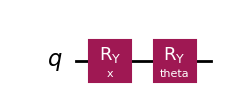

In [9]:
from qiskit import QuantumCircuit


qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qc.draw('mpl')

<a name="task24"></a>
### Task 2.4: QNN

Create a QNN using the [EstimatorQNN](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) class provided by Qiskit Machine Learning.

This class expects a quantum circuit containing both a variational form and an ansatz. Additionally, the parameters for each must be explicitly specified using the arguments `input_params` and `weight_params`, respectively. Visit the link to see how.

### Solution

In [10]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

qnn = EstimatorQNN(
    circuit=qc,                               # circuit created in task 2.3
    input_params=feature_map.parameters,      # parameters of the feature map created in task 2.1
    weight_params=ansatz.parameters           # parameters of the ansatz created in task 2.2
)

<a name="task25"></a>
### Task 2.5: Regressor

Create a basic quantum neural network regressor using the [NeuralNetworkRegressor](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.NeuralNetworkRegressor.html) class provided by Qiskit Machine Learning. This is necessary to specialize the QNN for our type of problem: regression.

- The main argument is the object containing the QNN, sent through the `neural_network` variable.

- You can specify the loss function with the `loss` argument; the default value is `'squared_error'`, but you can experiment with others.

- Using the optimizer argument, you specify a class with which you want to train the QNN. First, try [L_BFGS_B](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.optimizers.L_BFGS_B.html) (Limited-memory BFGS Bound), and if you wish, experiment with other [optimizers](https://qiskit-community.github.io/qiskit-machine-learning/apidocs/qiskit_machine_learning.optimizers.html). Optimizers have their own parameters that you can experiment with.

- An optional but very useful argument is `callback`, in which you can specify a function to be executed as the training progresses. Below is a function (`callback_plot`) that plots the progress of the cost function value. Include it when creating the `NeuralNetworkRegressor`.

In [11]:
from IPython.display import clear_output, display
import time

objective_func_vals = []                              # to store the full history

def callback_plot(weights, obj_func_eval):
  plt.clf()
  objective_func_vals.append(obj_func_eval)
  plt.title("Loss function value versus iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  display(plt.gcf())
  clear_output(wait=True)
  time.sleep(1)                                       # to reduce the speed of the plot updates

### Solution

In [12]:
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit_machine_learning.optimizers import L_BFGS_B


regressor = NeuralNetworkRegressor(
    neural_network=qnn,                 # QNN created in task 2.4
    loss="squared_error",               # loss function
    optimizer=L_BFGS_B(),               # optimizer
    callback=callback_plot,             # function that will plot the value of the loss function
)

<a name="task26"></a>
### Task 2.6: Training

Train the regressor by calling the `NeuralNetworkRegressor.fit()` method, which receives the samples (`X`) and labels (`y`).

Check how well the model performed by calling the `NeuralNetworkRegressor.score()` method, using the same `X` and `y`.

### Solution

0.9854655747608971

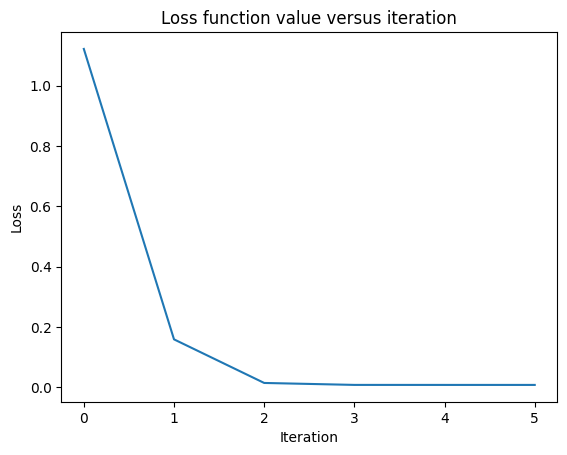

In [13]:
objective_func_vals = []    # we make sure the history is empty

regressor.fit(X, y)         # adjust the data

regressor.score(X, y)       # get the score

---

Finally, let's look at the result of the regressor with the help of the `NeuralNetworkRegressor.predict()` method to observe the function it fitted.

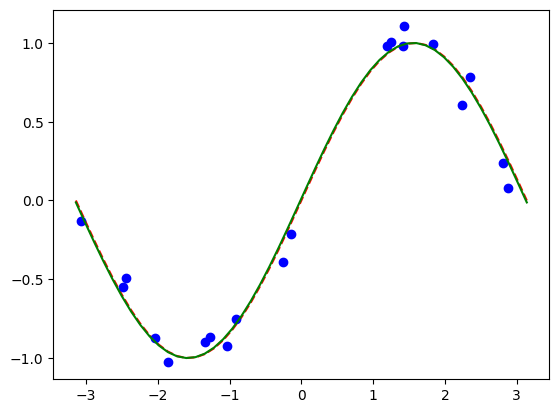

In [14]:
plt.plot(X_, f(X_), "r--")          # plot the original function (in red)

plt.plot(X, y, "bo")                # plot the samples (in blue)

y_ = regressor.predict(X_)          # suppose the NeuralNetworkRegressor object was created in the variable 'regressor'

plt.plot(X_, y_, "g-")              # plot the fitted curve (in green)
plt.show()